# Sleep Apnea Detection Pipeline

This notebook loads EDF and XML files, preprocesses relevant signals, labels apnea events, and trains a 1D CNN using Keras Tuner.

- SpO₂ and HR sampled at 1 Hz
- Thoracic and Abdominal Respiratory Effort sampled at 10 Hz
- Segment length: 60 seconds
- Label: presence of apnea event

In [68]:
import os
from pathlib import Path
import numpy as np
import pyedflib
import xml.etree.ElementTree as ET
from scipy.signal import resample
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.utils import resample as sklearn_resample
import pandas as pd




In [75]:
# Define paths (cross-platform)
base_dir = Path("../project")
edf_dir = base_dir / "edf_data"
xml_dir = base_dir / "annotations"
preprocessed_dir = base_dir / "preprocessed"
preprocessed_dir.mkdir(parents=True, exist_ok=True)
model_dir = base_dir / "model"

In [70]:
# Load and resample signals
def load_signals(edf_path):
    f = pyedflib.EdfReader(str(edf_path))
    signals = {}
    for i in range(f.signals_in_file):
        label = f.getLabel(i).lower()
        sig = f.readSignal(i)
        if "sao2" in label:
            signals["sao2"] = sig
        elif "pr" in label or "heart" in label:
            signals["pr"] = sig
        elif "thor res" in label:
            signals["thor res"] = resample(sig, len(sig)//10)
        elif "abdo res" in label:
            signals["abdo res"] = resample(sig, len(sig)//10)
    f.close()
    return signals

In [71]:
# Segment into 60-second windows
def window_signals(signals, window_size=60):
    min_len = min(len(signals[k]) for k in signals)
    num_windows = min_len // window_size
    X = []
    for i in range(num_windows):
        window = [signals[key][i*window_size:(i+1)*window_size] for key in ["sao2", "pr", "thor res", "abdo res"]]
        X.append(np.stack(window, axis=-1))
    return np.array(X)

In [72]:
# Extract apnea labels from XML
def extract_apnea_events(xml_path):
    apnea_events = []
    root = ET.parse(xml_path).getroot()

    for event in root.iter('ScoredEvent'):
        concept = event.findtext('EventConcept') or ''
        if 'apnea' in concept.lower():
            try:
                start = float(event.findtext('Start'))
                duration = float(event.findtext('Duration'))
                apnea_events.append((start, duration))
            except (TypeError, ValueError):
                continue
    return apnea_events

def label_windows(window_count, apnea_events, window_size=60):
    labels = []
    for i in range(window_count):
        w_start = i * window_size
        w_end = w_start + window_size
        label = any(s < w_end and (s + d) > w_start for s, d in apnea_events)
        labels.append(int(label))
    return np.array(labels)

In [73]:
def plot_window(X, y, window_index=0):
    signal_names = ['SpO₂', 'HR', 'Thoracic', 'Abdominal']
    time = range(60)
    label = y[window_index]
    label_text = 'Apnea' if label == 1 else 'No Apnea'

    plt.figure(figsize=(12, 6))
    for i in range(4):
        plt.plot(time, X[window_index][:, i], label=signal_names[i])

    plt.xlabel("Time (seconds)")
    plt.ylabel("Signal Value")
    plt.title(f"Window #{window_index} - {label_text}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [74]:
def get_subject_id(filename):
    return filename.split("-")[1][:6]

edf_files = [f for f in os.listdir(edf_dir) if f.endswith(".edf")]
subject_ids = []

for edf in edf_files:
    sid = get_subject_id(edf)
    xml_path = os.path.join(xml_dir, f"shhs2-{sid}-nsrr.xml")
    if os.path.exists(xml_path):
        subject_ids.append(sid)

subject_ids = sorted(list(set(subject_ids)))
print(f"Found {len(subject_ids)} subjects with both EDF and XML")

# Shuffle subject IDs
np.random.seed(42)
np.random.shuffle(subject_ids)

# Split subjects
n = len(subject_ids)
train_ids = subject_ids[:int(n*0.7)]
val_ids   = subject_ids[int(n*0.7):int(n*0.9)]
test_ids  = subject_ids[int(n*0.9):]

print(f"{len(train_ids)} train, {len(val_ids)} val, {len(test_ids)} test subjects")

# Utility to load + preprocess one subject
all_X, all_y, all_meta, processed_ids = [], [], [], []

for sid in subject_ids:
    print(f"Processing subject {sid}, Number {subject_ids.index(sid)+1} of {n}")
    edf_path = os.path.join(edf_dir, f"shhs2-{sid}.edf")
    xml_path = os.path.join(xml_dir, f"shhs2-{sid}-nsrr.xml")
    
    if not os.path.exists(edf_path) or not os.path.exists(xml_path):
        print(f"Missing files for subject {sid}")
        continue
    
    try:
        signals = load_signals(edf_path)
        if len(signals) < 4:
            print(f"Missing signals in {edf_path}")
            continue
        
        X = window_signals(signals)  # Shape: (n_windows, 60, 4)
        events = extract_apnea_events(xml_path)  # List of (start, duration)
        y = label_windows(len(X), events)  # binary labels   
        all_X.append(X)
        all_y.append(y)
        all_meta.append({"id": sid, "duration_min": len(X), "apnea_count": sum(y)})
        processed_ids.append(sid)
    except Exception as e:
        print(f"Error processing {sid}: {e}")

# Convert to array
data = list(zip(processed_ids, all_X, all_y, all_meta))

# Now split sets based on subject ID
train_set = [(x, y) for (id_, x, y, meta) in data if id_ in train_ids]
val_set   = [(x, y) for (id_, x, y, meta) in data if id_ in val_ids]
test_set  = [(id_, x, y, meta) for (id_, x, y, meta) in data if id_ in test_ids]

Found 228 subjects with both EDF and XML
159 train, 46 val, 23 test subjects
Processing subject 205098, Number 1 of 228
Processing subject 201445, Number 2 of 228
Processing subject 200316, Number 3 of 228
Processing subject 204093, Number 4 of 228
Processing subject 200562, Number 5 of 228
Processing subject 204037, Number 6 of 228
Processing subject 200801, Number 7 of 228
Processing subject 203967, Number 8 of 228
Processing subject 203112, Number 9 of 228
Processing subject 202582, Number 10 of 228
Processing subject 204923, Number 11 of 228
Processing subject 200646, Number 12 of 228
Missing signals in ..\project\edf_data\shhs2-200646.edf
Processing subject 201843, Number 13 of 228
Processing subject 203669, Number 14 of 228
Processing subject 205522, Number 15 of 228
Processing subject 202825, Number 16 of 228
Processing subject 203011, Number 17 of 228
Processing subject 200942, Number 18 of 228
Processing subject 205631, Number 19 of 228
Processing subject 203776, Number 20 of 

In [76]:

X_train_all = np.concatenate([x for (x, y) in train_set], axis=0)
y_train_all = np.concatenate([y for (x, y) in train_set], axis=0)

print(f"Before balancing, training set shape: {X_train_all.shape}, labels: {np.bincount(y_train_all)}")

# Find apnea and non-apnea indices
apnea_idx = np.where(y_train_all == 1)[0]
non_apnea_idx = np.where(y_train_all == 0)[0]

if len(apnea_idx) == 0:
    print("Warning: No apnea samples in training data!")
else:
    # Downsample majority class (non-apnea) to match minority class size
    non_apnea_downsampled = sklearn_resample(non_apnea_idx,
                                    replace=False,
                                    n_samples=len(apnea_idx),
                                    random_state=42)

    balanced_indices = np.concatenate([apnea_idx, non_apnea_downsampled])
    np.random.shuffle(balanced_indices)

    # Balanced training data
    X_train_balanced = X_train_all[balanced_indices]
    y_train_balanced = y_train_all[balanced_indices]
    print(f"After balancing, training set shape: {X_train_balanced.shape}, labels: {np.bincount(y_train_balanced)}")


Before balancing, training set shape: (95365, 60, 4), labels: [70722 24643]
After balancing, training set shape: (49286, 60, 4), labels: [24643 24643]


In [77]:
# Model building function for Keras Tuner
def model_builder(hp):
    model = Sequential()
    n_layers = hp.Int('num_layers', 2, 6)
    filters = hp.Choice('feature_maps', [64, 96, 128, 160, 192, 224, 256])
    kernel = hp.Choice('kernel_size', [3, 5, 7, 9, 11])
    dropout = hp.Choice('dropout', [0.1, 0.2, 0.3, 0.4, 0.5])

    for i in range(n_layers):
        if i == 0:
            model.add(Conv1D(filters, kernel, activation='relu', input_shape=(60, 4)))
        else:
            model.add(Conv1D(filters, kernel, activation='relu', padding='same'))
        model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())

    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [78]:
# Hyperparameter tuning
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='tuner',
                     project_name='apnea')

tuner.search(X_train_balanced, y_train_balanced, validation_data=(X_val, y_val), epochs=50)

X_train shape: (480, 60, 4)
Reloading Tuner from tuner\apnea\tuner0.json


In [79]:
def compute_ahi(preds, total_minutes):
    """AHI = number of apnea windows per hour"""
    apnea_windows = (preds >= 0.5).sum()
    return apnea_windows / (total_minutes / 60)


# Concatenate for training
X_train = np.concatenate([x for x, y in train_set])
y_train = np.concatenate([y for x, y in train_set])
X_val = np.concatenate([x for x, y in val_set])
y_val = np.concatenate([y for x, y in val_set])

# Train best model from tuner or directly compile best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.fit(X_train_balanced, y_train_balanced, validation_data=(X_val, y_val), epochs=10)

# AHI evaluation on test subjects
results = []

for sid, X_test, y_test, meta in test_set:
    preds = best_model.predict(X_test).flatten()
    ahi = compute_ahi(preds, meta["duration_min"])
    true_ahi = sum(y_test) / (meta["duration_min"] / 60)
    results.append({
        "subject": sid,
        "AHI_Predicted": ahi,
        "AHI_True": true_ahi
    })

ahi_df = pd.DataFrame(results)
print(ahi_df)


c:\Users\Nikla.RECHENMASCHINE\anaconda3\envs\tfenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


c:\Users\Nikla.RECHENMASCHINE\anaconda3\envs\tfenv\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1541/1541 ━━━━━━━━━━━━━━━━━━━━ 78s 49ms/step - accuracy: 0.7162 - loss: 0.6179 - val_accuracy: 0.6632 - val_loss: 0.5725
Epoch 2/10
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 77s 50ms/step - accuracy: 0.7967 - loss: 0.4579 - val_accuracy: 0.7865 - val_loss: 0.4663
Epoch 3/10
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 74s 48ms/step - accuracy: 0.8039 - loss: 0.4417 - val_accuracy: 0.3760 - val_loss: 1.2222
Epoch 4/10
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 76s 49ms/step - accuracy: 0.8098 - loss: 0.4313 - val_accuracy: 0.4356 - val_loss: 0.7499
Epoch 5/10
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 77s 50ms/step - accuracy: 0.8137 - loss: 0.4233 - val_accuracy: 0.7677 - val_loss: 0.5064
Epoch 6/10
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 78s 51ms/step - accuracy: 0.8183 - loss: 0.4130 - val_accuracy: 0.7856 - val_loss: 0.4833
Epoch 7/10
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 74s 48ms/step - accuracy: 0.8172 - loss: 0.4134 - val_accuracy: 0.7717 - val_loss: 0.5094
Epoch 8/10
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 76s 50ms/step - accuracy: 0.8173 - loss: 0.40

In [80]:
# Evaluate best model
best_model = tuner.get_best_models(num_models=1)[0]
loss, acc = best_model.evaluate(X_val, y_val)
best_model.save(model_dir / "best_apnea_model.keras")
print("Best model saved to:", model_dir / "best_apnea_model.keras")
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.2f}")

c:\Users\Nikla.RECHENMASCHINE\anaconda3\envs\tfenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Nikla.RECHENMASCHINE\anaconda3\envs\tfenv\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


879/879 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7476 - loss: 2.4129
Best model saved to: ..\project\model\best_apnea_model.keras
Validation Loss: 2.4075
Validation Accuracy: 0.75


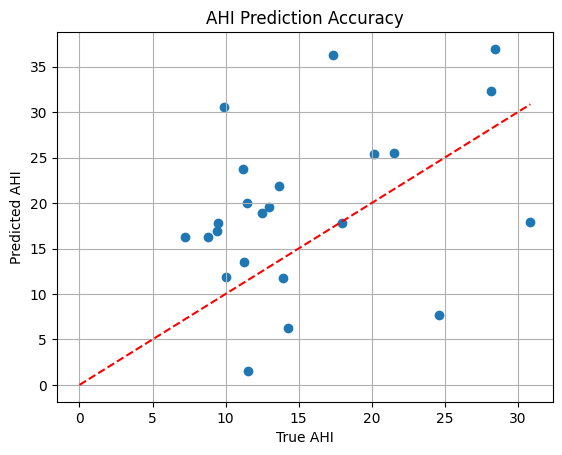

In [81]:
plt.scatter(ahi_df["AHI_True"], ahi_df["AHI_Predicted"])
plt.plot([0, max(ahi_df["AHI_True"])], [0, max(ahi_df["AHI_True"])], 'r--')
plt.xlabel("True AHI")
plt.ylabel("Predicted AHI")
plt.title("AHI Prediction Accuracy")
plt.grid(True)
plt.show()
